In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring
from Convience_fun import create_scenario
import warnings
warnings.filterwarnings("ignore")
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Scenario

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.parameters import Constant
import itertools

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [3]:
uncertainties = Scenario("SCEN1",**{'discount rate 0': 0,
    'discount rate 1': 0,
    'discount rate 2': 0,
    'A.0_ID flood wave shape': 0,
    'A.1_Bmax': 200,
    'A.1_pfail': 0.9833438536152244,
    'A.1_Brate': 1 ,
    'A.2_Bmax': 200,
    'A.2_pfail': 0.9601872768253088,
    'A.2_Brate': 1,
    'A.3_Bmax': 200,
    'A.3_pfail': 0.951145688071847,
    'A.3_Brate': 1,
    'A.4_Bmax': 200,
    'A.4_pfail': 1,
    'A.4_Brate': 1,
    'A.5_Bmax': 200,
    'A.5_pfail': 0.29973752703517675,
    'A.5_Brate': 1})

In [4]:
with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(uncertainties,1000)

100%|██████████████████████████████████████| 1000/1000 [06:11<00:00,  2.69it/s]


In [5]:
experiments, outcomes = results

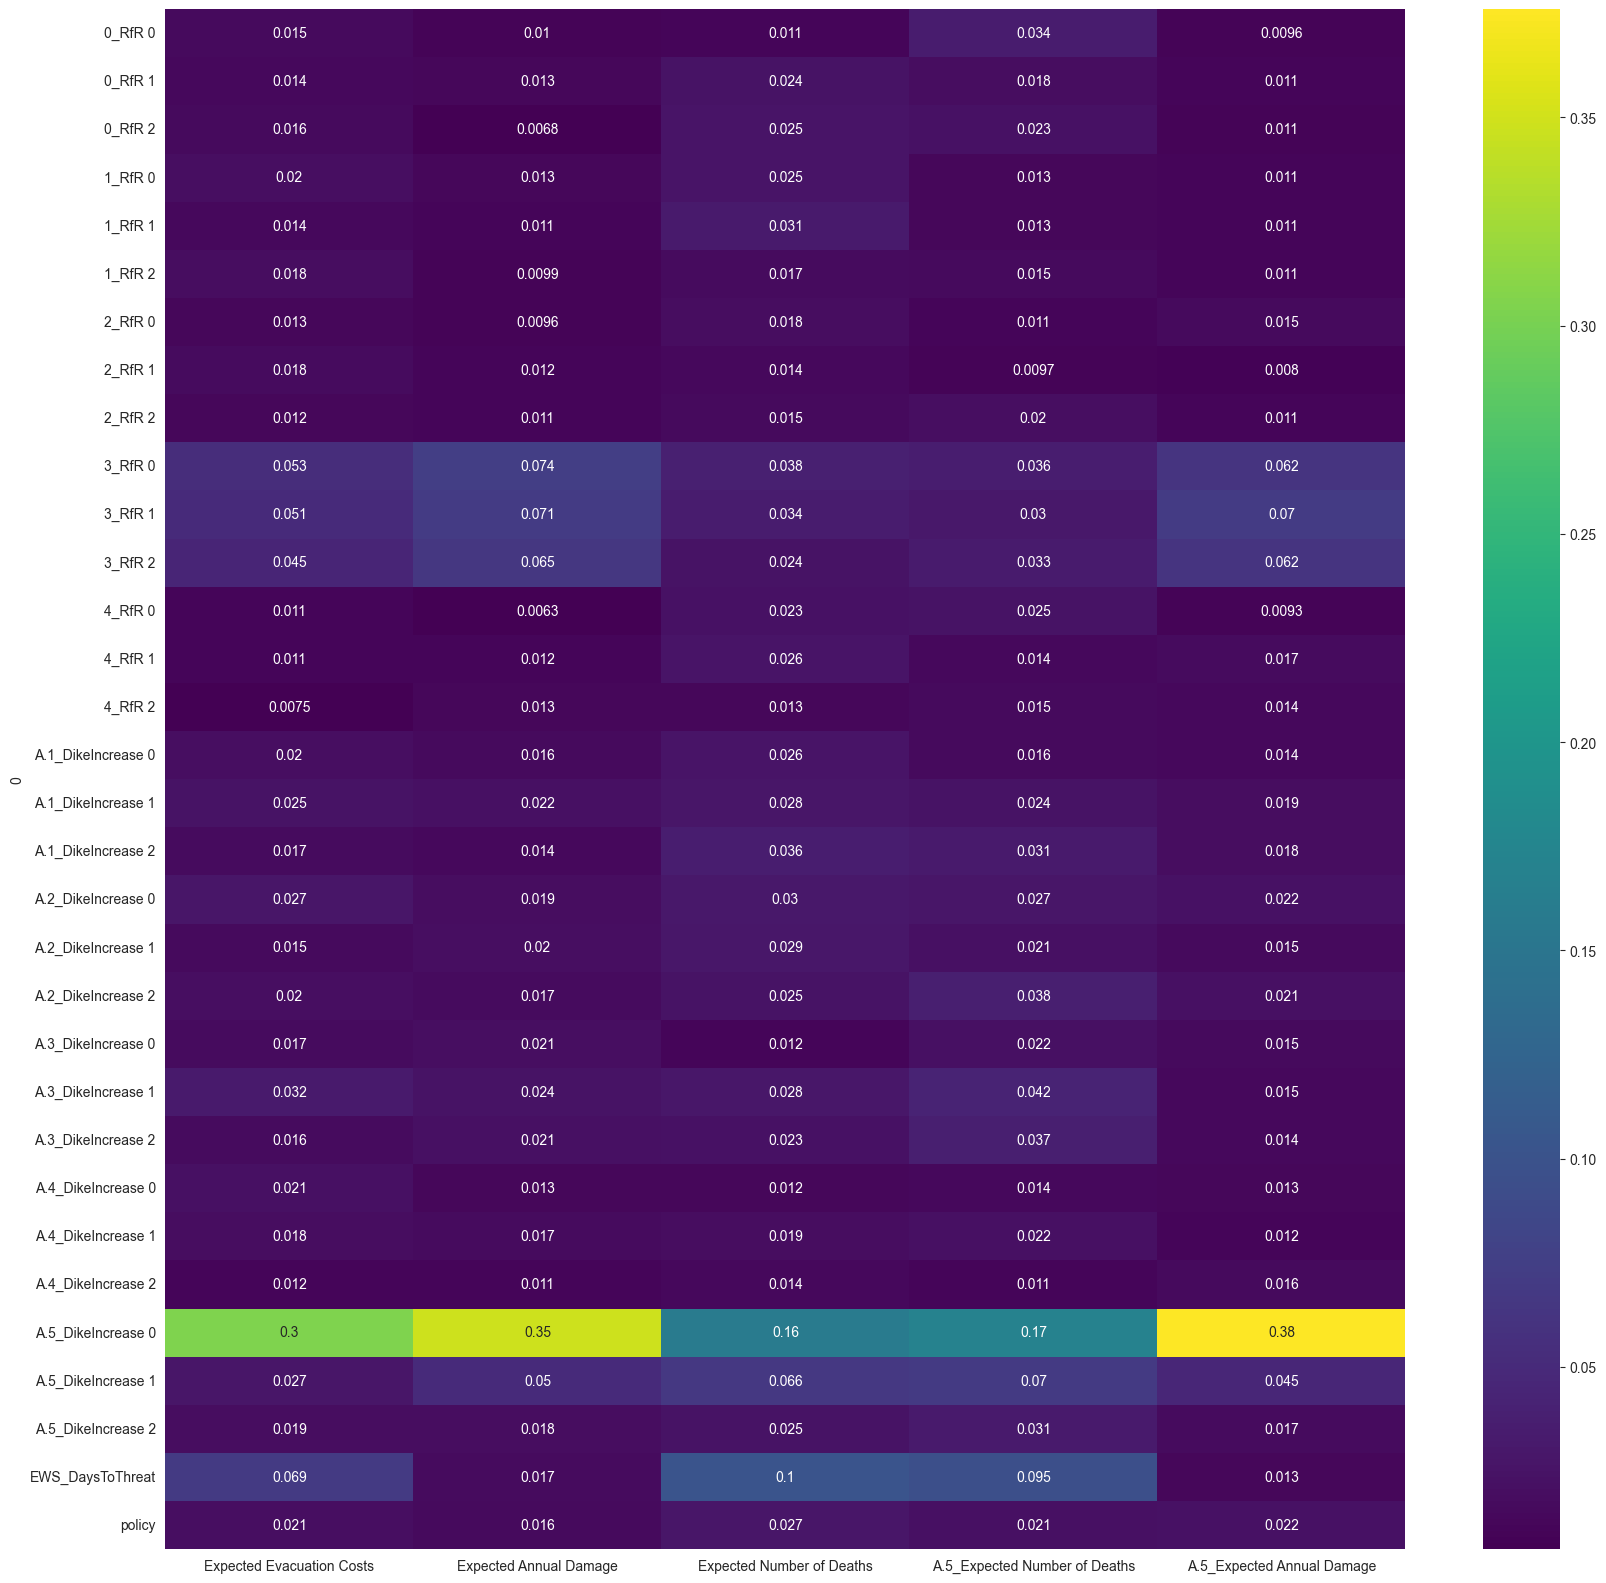

In [6]:
experiments_unc = experiments.iloc[:, 19:]
outcomes.keys()
df = pd.DataFrame(outcomes)

# df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df[
#     "A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
# df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
#     "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
df_feature_importance_out = df[["Expected Evacuation Costs","Expected Annual Damage", "Expected Number of Deaths", "A.5_Expected Number of Deaths", "A.5_Expected Annual Damage"]]

x = experiments_unc
y = df_feature_importance_out
fig, ax = plt.subplots(figsize=(20,20))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,ax=ax)
plt.show()

### SOBOL

In [7]:
# with MultiprocessingEvaluator(dike_model_1) as evaluator:
#     results = evaluator.perform_experiments(scenarios=20,policies=policy0,uncertainty_sampling=Samplers.SOBOL)

In [8]:
with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(uncertainties,20,lever_sampling=Samplers.SOBOL)

100%|██████████████████████████████████████| 1280/1280 [11:18<00:00,  1.89it/s]


In [9]:
experiments_unc = experiments.iloc[:, 19:-3]

In [10]:
df = pd.DataFrame(outcomes)
# df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
#     "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
# 
# df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]

df_feature_importance_out = df[["Expected Annual Damage", "Expected Number of Deaths","A.5_Expected Annual Damage", "A.5_Expected Number of Deaths", "A.5 Total Costs"]]
## Feature importance


In [11]:
# outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]
# outcomes["Expected Annual Damage"] = df["Expected Annual Damage"]

RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

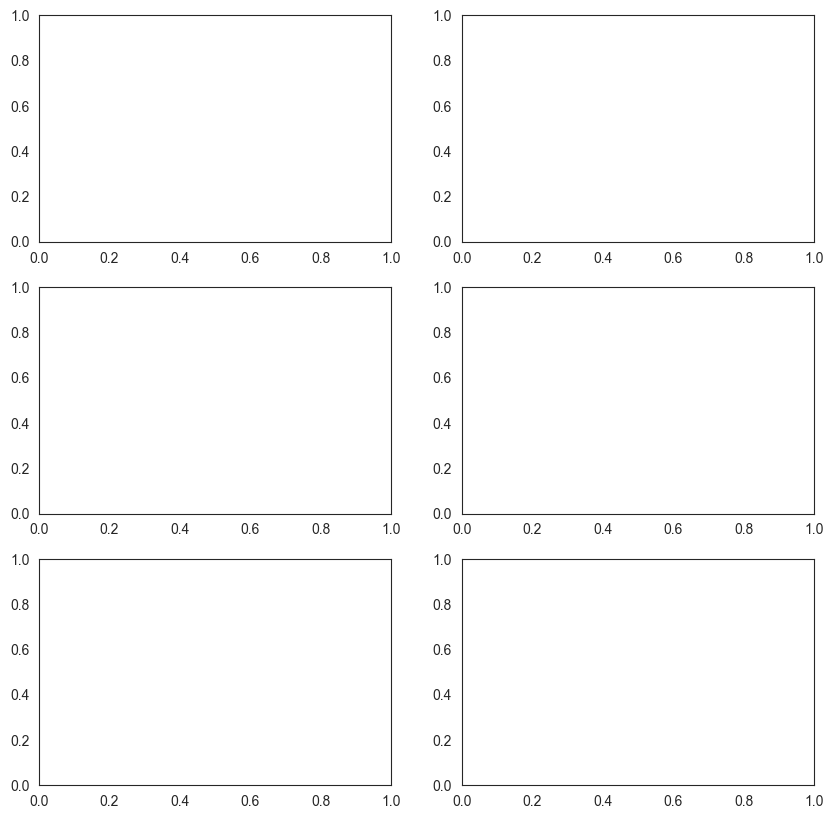

In [12]:
problem = get_SALib_problem(dike_model.levers)

sns.set_style('white')
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()

for index, kpi in enumerate(df_feature_importance_out.columns):
    Si = sobol.analyze(problem, np.array(outcomes[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]
    ax[index].title.set_text(kpi)
    indices.plot.bar(yerr=err.values.T, ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()